# 1D Diffusion

This tutorial illustrates some basic features of the `stochrare` package with simple 1D diffusion processes.

First, let us import standard packages: `numpy` and `matplotlib`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Monte-Carlo simulation of 1D diffusions

One of the very common tasks `stochrare` can be used for is sampling trajectories of a stochastic process, or estimating directly some statistical properties of the process.
We have tried to design the package so that such tasks can be easily fulfilled with an intuitive interface.
The generic class for 1D diffusion processes is `stochrare.dynamics.diffusion1d.DiffusionProcess1D`.
As we shall see later in this tutorial, any 1D diffusion process can be represented as members of this class, simply by providing the drift and diffusion functions to the constructor.
But the package also ships with predefined standard processes, like the Wiener process.
Let us import this process:

In [2]:
from stochrare.dynamics.diffusion1d import Wiener1D

### Sample paths

First, we seed the random number generator with a fixed value, so that the results are always the same when we run the whole notebook.
Of course, if you run a given cell multiple times, you will get different realizations of the stochastic processes.

In [3]:
np.random.seed(seed=100)

The basic tool to generate sample paths is the `trajectory` method. It integrates numerically stochastic differential equations of the form:
$$ dX_t = F(X_t, t) + \sigma(X_t, t) dW_t.$$

Let us start by plotting sample paths of the Wiener process $W$ (also known as *Brownian motion*) with a one-liner:

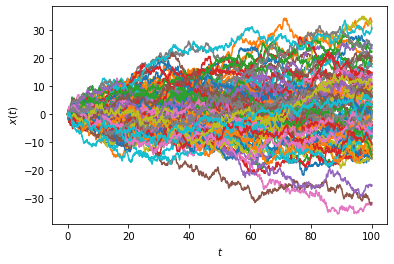

In [4]:
Wiener1D().trajectoryplot(*[Wiener1D().trajectory(0.,0.,T=100) for _ in range(100)]);

Or, in a different style:

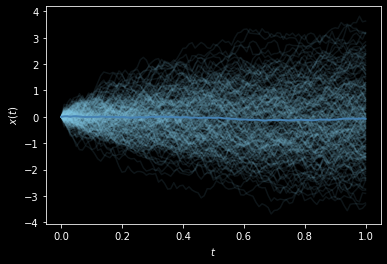

In [5]:
from stochrare.io.plot import trajectory_plot1d
def ensemble_plot1d(*args, **kwargs):
    fig, ax = trajectory_plot1d(*((t, x, {'color': 'skyblue', 'alpha': 0.1}) for t, x in args), **kwargs)
    ax.plot(*np.array(args).mean(axis=0), color='steelblue', lw=2)
    return fig, ax
with plt.style.context(('dark_background')):
    ensemble_plot1d(*[Wiener1D().trajectory(0., 0., T=1, dt=0.01) for _ in range(200)]);

We have used two convenience methods that we provide for making quick plots: `trajectory_plot1d`, which is a function from the `stochrare.io.plot` submodule, and `trajectoryplot`, a method of `DiffusionProcess1D` objects which just provides an interface to `trajectory_plot1d` for quick access, and which can be overriden by subclasses to systematically include specific details in trajectory plots.

### Observables and PDFs

We now estimate some statistical properties of stochastic processes.

Let us first check that for the Brownian motion the mean square displacement increases linearly with time:

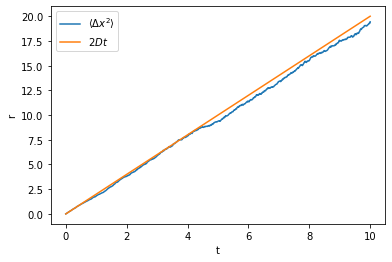

In [6]:
ensemble = np.array([Wiener1D().trajectory(0., 0., T=10, dt=0.01) for _ in range(1000)])
time = np.average(ensemble[:, 0, :], axis=0)
ax = plt.axes(xlabel='t', ylabel='r')
ax.plot(time, np.average(ensemble[:, 1, :]**2, axis=0), label=r'$\langle \Delta x^2 \rangle$')
ax.plot(time, 2*time, label=r'$2Dt$')
ax.legend()
plt.show()

Now we estimate the probability for the stochastic process to take value $x$ at time $t$, knowing the initial condition $X_{t_0}=x_0$, i.e. the transition probability $p(x, t | x_0, t_0)$.
For this, the `empirical_vector` method should be used: it simulates on the fly an ensemble of sample paths and returns the histogram of the values at each desired time.

Again, we work with the Wiener process, for which an analytical solution is known:
$$ p(x, t | 0, 0) = \frac{1}{\sqrt{4\pi D t}}e^{-x^2/4Dt}. $$

This solution is hard-coded in the `Wiener1D` class, in the `_fpthsol` method.

Both solutions are represented using the `pdf_plot1d` function, another tool for quick plots dedicated to probability distributions.
In the figure below, the Monte-Carlo estimate is the solid line and the theoretical result is the dotted line.

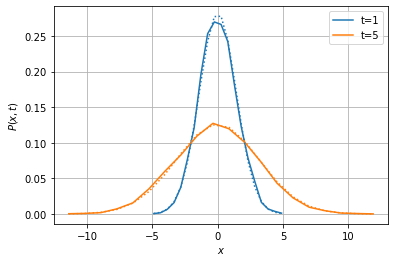

In [7]:
from stochrare.io.plot import pdf_plot1d
pdf = list(Wiener1D().empirical_vector(0, 0, 10000, 1, 5, bins=20))
fig, ax, lines = pdf_plot1d(*((0.5*(xx[1:]+xx[:-1]), pp, {'label': f't={t}'}) for t, pp, xx in pdf));
pdf_plot1d(*((0.5*(xx[1:]+xx[:-1]), Wiener1D()._fpthsol(0.5*(xx[1:]+xx[:-1]), t), 
              {'ls': 'dotted', 'color': l.get_color()}) for l, (t, _, xx) in zip(lines, pdf)),
           fig=fig, ax=ax);

### Numerical convergence

The sample paths computed with the `trajectory` method are discrete approximations of the sample paths of the stochastic differential equation, using the Euler-Maruyama method, which consists in computing a sequence of random numbers $X_n$ defined by:
$$ X_{n+1} = X_n + F(X_n, t_n)\Delta t + \sigma(X_n, t_n) \Delta W_n,$$

where $t_n$ is the sample time, $\Delta t = t_{n+1}-t_n$ the time step of the method and $\Delta W_n = W_{t_{n+1}}-W_{t_n}$ a Gaussian random variable with zero mean and variance $\Delta t$.

Let us now illustrate the numerical convergence of the Euler-Maruyama method. For this, we precompute the Brownian path with respect to which we integrate the SDE, and we vary the time step used for the Euler-Maruyama method.

We do this for a stochastic process which can be analytically solved:
$$ dX_t = 2X_t dt + X_t dW_t,$$

and compare the numerical approximation to the analytical solution, $X_t = X_0 e^{3t/2+W_t}$.
This stochastic process is easily constructed through the constructor of the generic class `DiffusionProcess1D`:

In [8]:
from stochrare.dynamics.diffusion1d import DiffusionProcess1D
model = DiffusionProcess1D(lambda x, t: 2*x, lambda x, t: x)

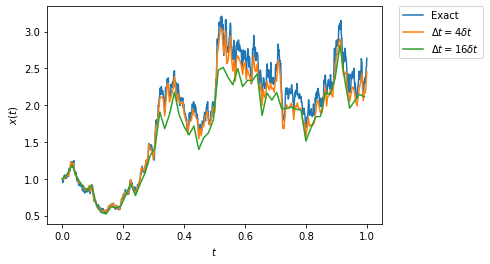

In [9]:
dt_brownian = 0.001
brownian_path = Wiener1D(D=0.5, deterministic=True).trajectory(0., 0., T=1, dt=dt_brownian)
model.trajectoryplot((brownian_path[0], np.exp(1.5*brownian_path[0]+brownian_path[1])),
                     model.trajectory(1., 0., T=1, dt=4*dt_brownian, brownian_path=brownian_path),
                     model.trajectory(1., 0., T=1, dt=16*dt_brownian, brownian_path=brownian_path),
                    labels=('Exact', r'$\Delta t= 4 \delta t$', r'$\Delta t = 16 \delta t$'));

Slightly more precisely, let us try to illustrate that the Euler-Maruyama has strong order of convergence $1/2$:
$$ \mathbb{E}|X_n-X_{t_n}| \leq C \Delta t^{1/2}.$$

Below, we plot the error on the final point as a function of the time step used in the Euler-Maruyama method, and we compare to a linear regression and to a reference line with slope $1/2$.

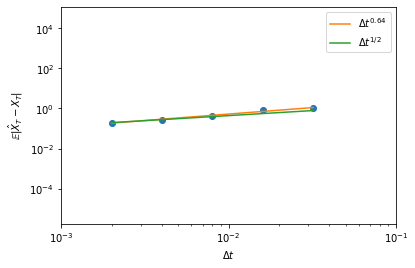

In [10]:
import scipy.stats

ensemble_size = 1000
dt_brownian = 0.002
dtarr = np.array((1, 2, 4, 8, 16))*dt_brownian
model = DiffusionProcess1D(lambda x, t : 2*x, lambda x, t: x)
trajs = np.array([[np.abs(model.trajectory(1., 0., T=1, dt=dt, 
                                           brownian_path=brownian_path)[1][-1]-np.exp(1.5*brownian_path[0][-1]+brownian_path[1][-1])) 
                   for dt in dtarr]
                  for brownian_path in (Wiener1D(D=0.5).trajectory(0., 0., T=1, dt=dt_brownian) for _ in range(ensemble_size))])
error = trajs.mean(axis=0)

ax = plt.axes(xlim=(0.001, 0.1), xlabel=r'$\Delta t$', ylabel=r'$\mathbb{E}|\hat{X}_T-X_T|$', xscale='log', yscale='log')
ax.scatter(dtarr, error)
slope, intercept, _, _, _ = scipy.stats.linregress(np.log10(dtarr), np.log10(error))
ax.plot(dtarr, 10**intercept*dtarr**slope, label=r'$\Delta t^{'+format(slope, '.2f')+'}$', color='C1')
ax.plot(dtarr, error[0]*(dtarr/dtarr[0])**0.5, label=r'$\Delta t^{1/2}$', color='C2')
ax.legend();

## Numerical solution of the Fokker-Planck equation

Above we have considered stochastic processes fron the standpoint of stochastic differential equations.
We now turn to an alternative point of view, the probability distribution.
Markov processes are fully determined by the transition probabilities $p(x',t'|x,t)$, which satisfy the Fokker-Planck equations:
$$ \frac{\partial P}{\partial t} = - \frac{\partial}{\partial x} [FP] + \frac{1}{2}\frac{\partial^2}{\partial x^2}[\sigma^2 P].$$

Some properties of stochastic processes are much more conveniently addressed in the Fokker-Planck framework: rather than requiring the simulation of many sample paths, probability distributions can be computed directly by solving a partial differential equation.

The package includes a basic finite-difference solver for the 1D Fokker-Planck equation.
We illustrate its use below.

Let us first import the submodule:

In [11]:
import stochrare.fokkerplanck as fp

All we need to do is create an object representing the Fokker-Planck equation (an instance of the `FokkerPlanck1D` class) and then use its `fpintegrate` method:

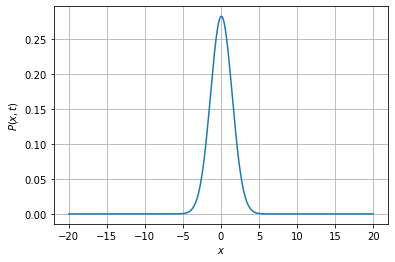

In [12]:
fpe = fp.FokkerPlanck1D(lambda x, t: 0, lambda x, t: 1)
t, X, P = fpe.fpintegrate(0, 1, dt=0.001, npts=400, bounds=(-20., 20.), P0=fpe.dirac1d(0, np.linspace(-20, 20, 400)), 
                          bc=('absorbing', 'absorbing'))
pdf_plot1d((np.array(X), np.array(P)), legend=False);

Note that we have provided as arguments to `fpintegrate` the domain on which to solve the equation (`bounds`), the space resolution (`npts`), the time step (`dt`), as well as the boundary conditions (`bc`; here they are both absorbing boundary conditions) and an initial distribution (`P0`).

`FokkerPlanck1D` objects offer another method to compute easily the probability distribution at different times: `fpintegrate_generator` is a generator yielding the pdf at times given as arguments (see API documentation for more information). It relies on `fpintegrate` under the hood.
For convenience, `ConstantDiffusionProcess1D` objects offer a `pdfplot` method which wraps the `FokkerPlanck1D.fpintegrate_generator` method.
As an example, the solution of the heat equation at different times can be obtained as a one-liner:

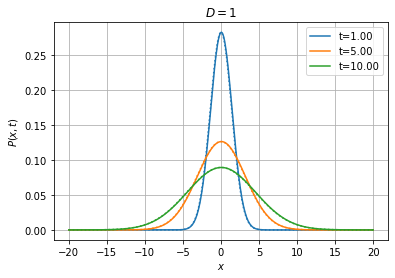

In [13]:
Wiener1D().pdfplot(1, 5, 10, dt=0.001, npts=400, bounds=(-20.0, 20.0), t0=0.0, 
                   P0=fpe.dirac1d(0, np.linspace(-20, 20, 400)), bc=('absorbing', 'absorbing'), th=True);

The theoretical solution is shown as a dotted line with the same color.

### Effect of Boundary Conditions

Above we have compared the solution of the Fokker-Planck equation with absorbing boundary conditions with the theoretical solution on an infinite domain. Discrepancies should start appearing when we reach the boundaries.

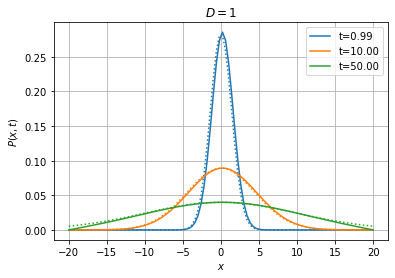

In [14]:
Wiener1D().pdfplot(1, 10, 50, dt=0.01, npts=100, bounds=(-20.0, 20.0), t0=0.0, 
                   P0=fpe.dirac1d(0, np.linspace(-20, 20, 100)), bc=('absorbing', 'absorbing'), th=True);

Below, we solve the equation with reflecting boundary conditions on both sides. In that case, we expect the system to reach a stationary state where the probability distribution is uniform on the interval.

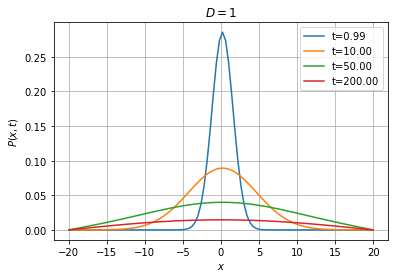

In [15]:
Wiener1D().pdfplot(1, 10, 50, 200, dt=0.01, npts=100, bounds=(-20.0, 20.0), t0=0.0, 
                   P0=fpe.dirac1d(0, np.linspace(-20, 20, 100)), bc=('reflecting', 'reflecting'));

### Comments on numerical aspects

With the default Euler time-stepping scheme, the time step $dt$ should be much smaller than $dx^2/D$, with $dx$ the spatial resolution and $D$ the diffusivity. For instance, if we decrease the diffusivity by a factor 10, we can afford to multiply the time step by the same factor (of course the probability distribution will spread 10 times slower).

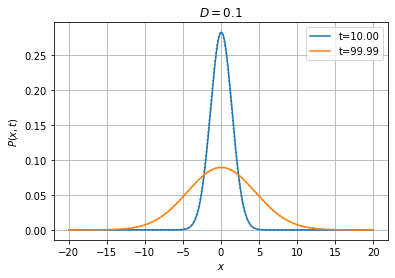

In [16]:
Wiener1D(D=0.1).pdfplot(10, 100, dt=0.01, npts=400, bounds=(-20.0, 20.0), t0=0.0, 
                        P0=fpe.dirac1d(0, np.linspace(-20, 20, 400)), bc=('absorbing', 'absorbing'), th=True);

With the *implicit* and *Crank-Nicolson* schemes, we can afford using much larger timesteps than with the explicit method, as illustrated below:

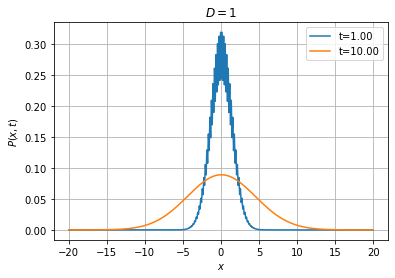

In [17]:
Wiener1D(D=1).pdfplot(1, 10, dt=0.005, npts=400, bounds=(-20.0, 20.0), t0=0.0, 
                      P0=fpe.dirac1d(0, np.linspace(-20, 20, 400)), bc=('absorbing', 'absorbing'), method='explicit');

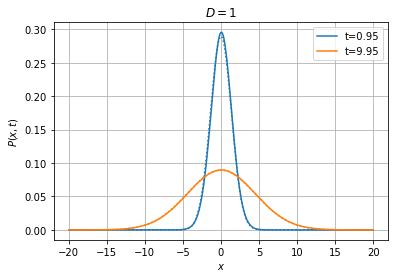

In [18]:
Wiener1D(D=1).pdfplot(1, 10, dt=0.05, npts=400, bounds=(-20.0, 20.0), t0=0.0, 
                      P0=fpe.dirac1d(0, np.linspace(-20, 20, 400)), bc=('absorbing', 'absorbing'), method='implicit', th=True);

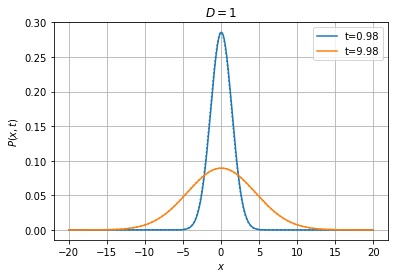

In [19]:
Wiener1D(D=1).pdfplot(1, 10, dt=0.025, npts=400, bounds=(-20.0, 20.0), t0=0.0, 
                      P0=fpe.dirac1d(0, np.linspace(-20, 20, 400)), bc=('absorbing', 'absorbing'), method='cn', th=True);